# 2022-03-02 • Duration & SNR for big-N–to–1

## Setup

In [20]:
#

In [21]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


## Params & sim

Short warm-up run. Get compilation out of the way.

In [5]:
p0 = ExperimentParams(
    sim = SimParams(
        input = previous_N_30_input,
        duration = 1 * minutes
    )
);

In [6]:
@time sim(p0.sim);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  3.929238 seconds (8.80 M allocations: 598.610 MiB, 11.79% gc time, 86.25% compilation time)


In [7]:
p = ExperimentParams(
    sim = SimParams(
        input = realistic_N_6600_input,
        duration = 0.2 * minutes,
        synapses = SynapseParams(
            Δg_multiplier = 0.066,
        ),
    )
);
dumps(p)

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 12.0
    Δt: 0.0001
    num_timesteps: 120000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 5200
      N_inh: 1300
      N_conn: 6500
      N: 6600
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      Δg_exc: 4.0e-10
      Δg_inh: 1.6e-9
      Δg_multiplier: 0.066
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: 10.0
      spike_SNR_dB: 20.0
      spike_height: 0.095
      σ_noise: 0.0095
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    rngseed: 22022022
  evaluation: EvaluationParams
    num_tested_neurons_per_grou

In [8]:
t, v, vimsig, input_spikes = @time sim(p.sim);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  4.708045 seconds (4.80 M allocations: 372.494 MiB, 2.00% gc time, 39.88% compilation time)


In [9]:
num_spikes = length.(input_spikes)

ComponentVector{Int64}(conn = (exc = [24, 18, 27, 22, 12, 23, 20, 6, 18, 18  …  20, 18, 26, 22, 7, 12, 26, 8, 22, 15], inh = [7, 19, 16, 1, 19, 13, 21, 22, 3, 14  …  27, 15, 21, 7, 22, 26, 20, 17, 18, 27]), unconn = [22, 18, 15, 22, 29, 17, 12, 29, 14, 14  …  29, 16, 20, 4, 28, 27, 28, 11, 10, 8])

## Plot

In [10]:
import PyPlot

In [11]:
using VoltageToMap.Plot

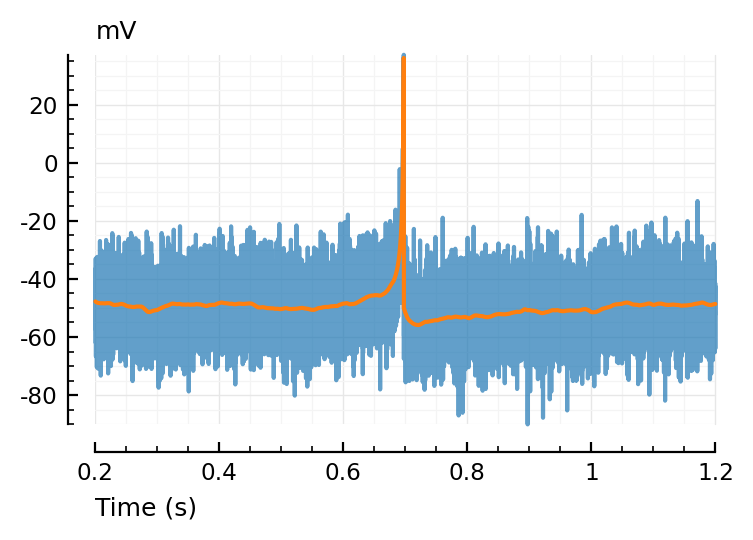

In [12]:
tzoom = [200, 1200]ms
ax = plotsig(t, vimsig / mV, tzoom; xlabel="Time (s)", hylabel="mV", alpha=0.7);
plotsig(t, v / mV, tzoom; ax);

## Test conntest

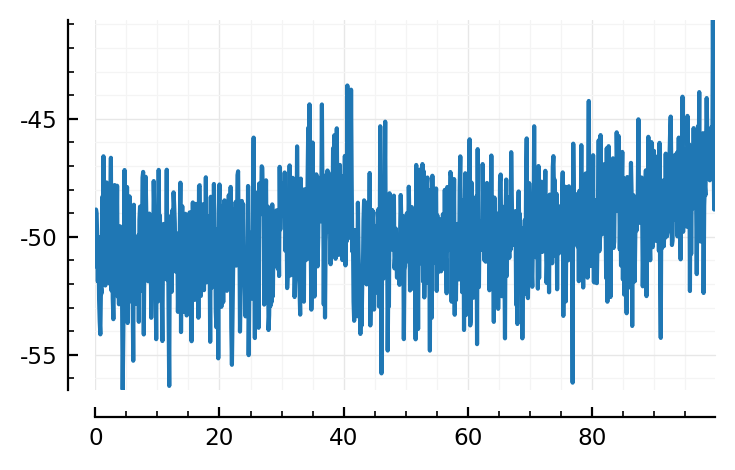

In [15]:
example_presynspikes = input_spikes.conn.exc[44]
plotSTA(vimsig, example_presynspikes, p);

In [19]:
p_value = test_connection(vimsig, example_presynspikes, p)

0.61

## Conntest performance

In [34]:
N_eval_trains = p.evaluation.num_tested_neurons_per_group

40

In [35]:
α = 0.05;

In [42]:
function evaluate_conntest_performance(vimsig, input_spikes, p)
    
    resetrng!(p.evaluation.rngseed)

    TP_exc = 0
    TP_inh = 0
    TP_unconn = 0

    for input_train in input_spikes.conn.exc[1:N_eval_trains]
        p_value = test_connection(vimsig, input_train, p)
        if p_value < α
            TP_exc += 1
        end
    end

    for input_train in input_spikes.conn.inh[1:N_eval_trains]
        p_value = test_connection(vimsig, input_train, p)
        if p_value > 1 - α
            TP_inh += 1
        end
    end

    for input_train in input_spikes.conn.exc[1:N_eval_trains]
        p_value = test_connection(vimsig, input_train, p)
        if α ≤ p_value ≤ 1 - α
            TP_unconn += 1
        end
    end

    TPR_exc    = TP_exc / N_eval
    TPR_inh    = TP_inh / N_eval
    TPR_unconn = TP_unconn / N_eval
    
    FPR = 1 - TPR_unconn
    
    return TPR_exc, TPR_inh, FPR
end;

In [44]:
evaluate_conntest_performance(vimsig, input_spikes, p)

(0.05, 0.025, 0.09999999999999998)

## Performance for given params

In [45]:
function performance_for(p::ExperimentParams)
    _t, _v, vimsig, input_spikes = sim(p.sim);
    return evaluate_conntest_performance(vimsig, input_spikes, p)
end;

In [54]:
const spike_height = cortical_RS.v_peak - cortical_RS.v_rest;

In [85]:
durations = [
    30 * seconds,
    1 * minutes,
    5 * minutes,
    10 * minutes,
    20 * minutes,
];

In [71]:
TPRs_exc = Vector{Float64}()
TPRs_inh = Vector{Float64}()
FPRs     = Vector{Float64}()

for duration in durations
    @show duration / minutes
    TPR_exc, TPR_inh, FPR = performance_for(
        ExperimentParams(
            sim = SimParams(;
                duration,
                imaging = VoltageImagingParams(;
                    spike_SNR = 40,
                    spike_height,
                ),
            ),
        )
    )
    @show TPR_exc, TPR_inh, FPR
    push!(TPRs_exc, TPR_exc)
    push!(TPRs_inh, TPR_inh)
    push!(FPRs, FPR)
    println()
end

duration / minutes = 0.5
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
(TPR_exc, TPR_inh, FPR) = (0.025, 0.025, 0.07499999999999996)

duration / minutes = 1.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
(TPR_exc, TPR_inh, FPR) = (0.075, 0.075, 0.050000000000000044)

duration / minutes = 5.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24
(TPR_exc, TPR_inh, FPR) = (0.05, 0.2, 0.125)

duration / minutes = 10.0
Progress:   6%|███                                      |  ETA: 0:02:14

LoadError: InterruptException:

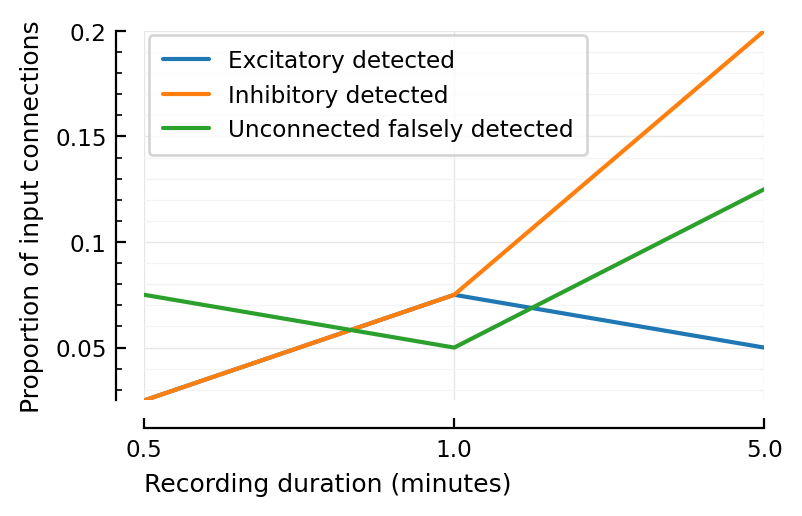

In [84]:
xticks = [1:length(durations);]
plott(rates; kwargs...) = plot(xticks, rates; xminorticks = false, kwargs...)

ax = plott(TPRs_exc, label="Excitatory detected")
ax = plott(TPRs_inh, label="Inhibitory detected")
ax = plott(FPRs, label="Unconnected falsely detected")

xlabels = durations / minutes .|> string
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_xlabel("Recording duration (minutes)")
ax.set_ylabel("Proportion of input connections")
ax.legend();

## Results

In [ ]:
resetrng!(20220222);

In [ ]:
num_trains = 40
println("Average p(shuffled trains with higher STA mean).")
println("(N = $(num_trains) input spike trains per category)")

p_exc    = Float64[]
p_inh    = Float64[]
p_unconn = Float64[]

for (groupname, spiketrains, pvals) in (
        ("excitatory",    input_spikes.conn.exc, p_exc),
        ("inhibitory",    input_spikes.conn.inh, p_inh),
        ("unconnected",   input_spikes.unconn, p_unconn),
    )
    for spiketrain in spiketrains[1:num_trains]
        push!(pvals, test_connection(spiketrain))
        print("."); flush(stdout)
    end
    @printf "%12s: %.3g\n" groupname mean(pvals)
end

In [ ]:
fig, ax = plt.subplots(figsize=(3.4,3))
function plotdot(y, x, c, jitter=0.28)
    N = length(y)
    x -= 0.35
    plot(x*ones(N) + (rand(N).-0.5)*jitter, y, "o", color=c, ms=4.2, markerfacecolor="none", clip_on=false)
    plot(x+0.35, mean(y), "k.", ms=10)
end
plotdot(p_exc,    1, "C2"); ax.text(1-0.16, -0.1, "excitatory"; color="C2", ha="center")
plotdot(p_unconn, 2, "C0"); ax.text(2-0.16, -0.1, "unconnected"; color="C0", ha="center")
plotdot(p_inh,    3, "C1"); ax.text(3-0.16, -0.1, "inhibitory"; color="C1", ha="center")
ax.boxplot([p_exc, p_unconn, p_inh], widths=0.2, medianprops=Dict("color"=>"black"))
set(ax, xlim=(0.33, 3.3), ylim=(0, 1), xaxis=:off)
hylabel(ax, L"p(\, \mathrm{shuffled\ \overline{STA}} \ > \ \mathrm{actual\ \overline{STA}}\, )"; dy=10);